**Supplementary material to "Revealing process and material parameter effects on densification via phase-field studies"**

This notebook shows that the model as presented is capable of reproducing non-uniform densification resulting from a gradient in grain size. For this, a simple square arrangement of particles is considered with a gradient in grain size in one direction. The strain is shown to be variable in the direction of the gradient, which implies non-uniform densification.

References: 

- Seiz2023b: https://doi.org/10.1007/s10853-023-08859-9

In [1]:
%matplotlib notebook
# notebook backend doesn't work on jupyterlab and widgets seems to die
# exclusively on binder, but works fine locally
# hence if you want interactivity in the plots:
# restart kernel, change the inline of the above to notebook and
# go to the notebook view via changing the url from
# https://hub.ovh2.mybinder.org/whatever/lab?
# to
# https://hub.ovh2.mybinder.org/whatever/tree/
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import glob
import matplotlib.patches as patches
import scipy
import scipy.sparse.linalg as linalg
import scipy.sparse as sparse
import random
import re
mpl.rcParams.update({'font.size': 16})
mpl.rcParams['figure.figsize'] = (8,4)  
X, Y = 0, 1
dirnames = {X: "X", Y: "Y"}
from helpers_dispmodel import *

What follows is a bit of setup. For geometry variation, adjust the parameters passed to makeGradiatedPacking.

In [2]:
def makeGradiatedPacking(rmin, nmax, steps, layercount):
    """
    Makes a rectangular packing, possibly with a gradient in grain size in y.
    
    rmin: starting radius
    nmax: number of particles to set in the smallest particle layer
    steps: number of particle radii to use; sizes will be r ~ rmin * 2**(n-1) with natural n < steps
    layercount: number of layers to set for each unique particle radius
    
    """
    if nmax < 2**(steps-1):
        print("increase nmax or you will be missing steps!")
        return np.nan, np.nan, np.nan
    nump = 0
    scalef = 2 # produces weird results for n!=2, generalization pending
    for i in range(steps):
        nump += layercount * nmax * (scalef)**(-i)
        # half the number of particles per step
    #layer0x = np.linspace(0, rmin*nmax, nmax)
    #layer0y = np.zeros(nmax)
    nump = int(np.ceil(nump))
    rad = np.zeros(nump)
    pos = np.zeros((DIM, nump))
    pcount = 0
    yoff = 0
    xoff = 0
    for i in range(steps):
        sizefac = scalef**i
        for lc in range(layercount):
            for k in range(nmax // int(sizefac)):
                radius = rmin * sizefac
                px = k * 2 * radius + xoff
                py = yoff
                
                rad[pcount] = radius * 1.1 # ensure contacts
                pos[:,pcount] = [px, py]
                pcount += 1
            yoff +=  radius * 2
        yoff += radius
        xoff += radius
    return rad, pos, nump

In [3]:
DIM= 2
rad, pos, totp = makeGradiatedPacking(1, 20, 3, 3) # rectangular, gradiated in y packing = variable strain
#rad, pos, totp = makeGradiatedPacking(1, 16, 1, 9) # rectangular packing of uniform size = constant strain

<IPython.core.display.Javascript object>


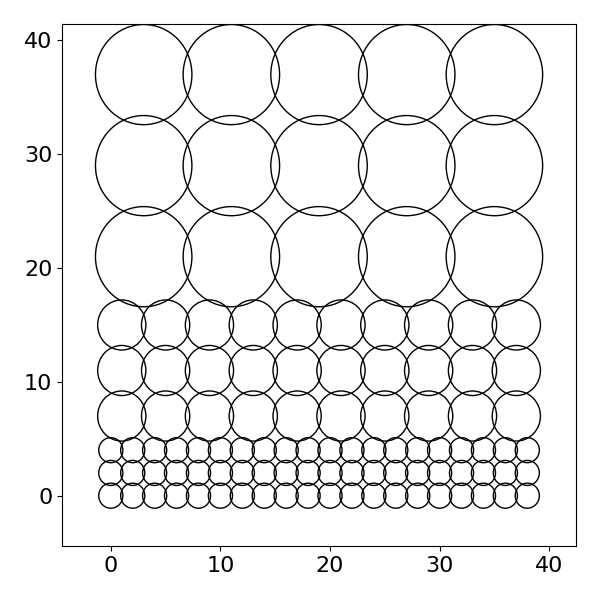

In [4]:
# quick 2D visualization of the packings w/ overlap
# this has limited applicability to the 3D packings, so it's above reading in those
fig, ax = plt.subplots(figsize=(6,6))

#ax.scatter(pos[0], pos[1])
xmin, xmax = np.min(pos[0,:])-np.max(rad)*1.01, np.max(pos[0,:])+np.max(rad)*1.01
ymin, ymax = np.min(pos[1,:])-np.max(rad)*1.01, np.max(pos[1,:])+np.max(rad)*1.01
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
note = False # True: show particle number
pps = range(totp) #range(totp) if totp < 200 else np.random.randint(0,totp,size=200)
for p in pps:
    #print(posen[0][p], posen[1][p], raden[p])
    pa = patches.Circle((pos[0][p], pos[1][p]), radius=rad[p], fill=False)
    ax.add_patch(pa)
    if note:
        ax.annotate(str(p+1), (pos[0][p], pos[1][p])
               # , fontsize=30
                   )
fig.tight_layout()

In [5]:
contacts, kd = getContacts_kd(pos, rad, varrad=True)

In [6]:
try:
    if testConnectivity(contacts):
        print ("ok to proceed")
    else:
        print("might be missing some connections, so some displacements will be nonsensical")
except Exception as e:
    print(e)

ok to proceed


In [7]:
sigma = 0*0.1 # 0 standard dev to remove random influence
mu=0.05 # mu set such that particles move "reasonably", i.e. less than a particle radius
posdep = lambda x: 0 #0
rdep = lambda r: mu/r # curvature # one could in take this to be gamma/r

In [8]:
def buildSystem_rdep(pos, rad, contacts, rhsmid=1.0, rhsspread=0.25, posdep=None, rdep=None):
    """
    Builds the system Cu=\Delta u as described in Seiz2023b, now with a radius dependence on the absorption rate.
    \Delta u = rhs is assumed to be a normal distribution, with the direction given by the grain boundary normal.
    rhsmid, rhsspread are the position (mean) and scale (stddev) of the normal distribution, cf. the numpy docs.
    posdep allows passing a single-argument function to give a spatial bias to the rhs; by default there is none.
    Its argument is assumed to be, for simplicity, only the x position of the particle

    Returns the system matrix C as a list of sparse matrices per dimension and a list of rhs per dimension.
    """
    dim, nump = pos.shape
    dokmats = []
    gbcounter = 0
    gbcount = getGBcount(contacts)
    rhsen = np.zeros((dim, gbcount))
    rhsscale = 1  # arbitrary number which scales the random distribution

    if posdep == None:  # avoid mutable default argument troubles
        posdep = lambda x: 0
    
    if rdep == None:  # avoid mutable default argument troubles
        rdep = lambda x: 0

    for d in range(dim):
        dokmats.append(sparse.dok_matrix((gbcount, 1 * nump)))
    for p in range(nump):
        for gbp in contacts[p]:
            # we assume that the grain boundary normal is given by the connecting vector of the COMs
            # this is just for the notebook, whereas in the PF code the grain boundary normal
            # is found by averaging grad(phia)-grad(phib) over each ab-interface
            gbtot = pos[:, p] - pos[:, gbp]
            norm = np.linalg.norm(gbtot, 2)
            gbtot /= norm

            rnd = np.random.normal(rhsmid, rhsspread)
            # a bias by the position *will* cause the fit solution to deviate, as it implies
            # a nonlinear profile
            rnd += posdep(pos[0, p])  # bias by 0th position = x
            rnd += rdep(0.5*(rad[p] + rad[gbp])) # take it as average between two particles
            for d in range(dim):
                gbn = gbtot[d]
                dokmats[d][gbcounter, p] = -1 * np.sign(gbn)
                dokmats[d][gbcounter, gbp] = 1 * np.sign(gbn)

                rhsen[d][gbcounter] = rnd * rhsscale * np.abs(gbtot[d])
            gbcounter += 1
    cscmats = [x.tocsc() for x in dokmats]
    return cscmats, rhsen


In [9]:
cmat, r = buildSystem_rdep(pos, rad, contacts, rhsmid=mu, rhsspread=sigma, posdep=posdep,
                          rdep = rdep)
inis = ini_pos(pos)

We can now solve for the displacement in the gradiated structure. Note that an explicit dependence of the RHS (= displacement jump magnitude between grains) on the particle radius was employed to approximate the effect of a smaller capillary pressure at larger particle radii.

In the first plot below we can see that as one would basically expect, larger particles move less (smaller arrows). The differential effect can be shown better by plotting both the reference and displaced configuration together.

<IPython.core.display.Javascript object>


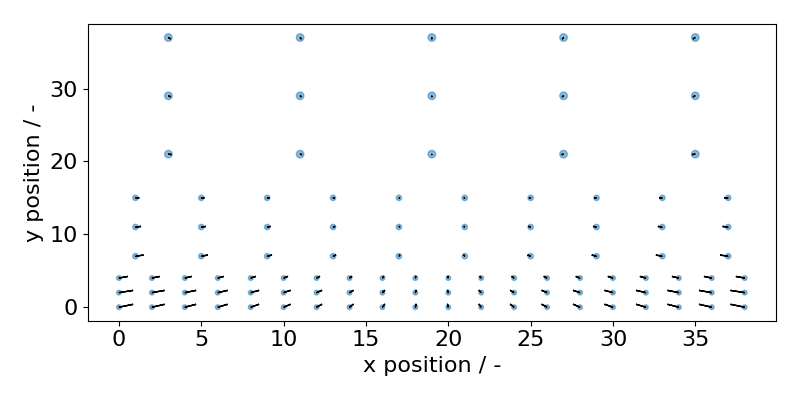

In [10]:
displ = np.zeros((2, totp))
for sdir in [X, Y]:
    ds = linalg.lsqr(cmat[sdir], r[sdir], x0=inis[sdir])[0]
    ds -= np.average(ds, weights=np.pi * rad**2)
    displ[sdir,:] = ds
    
    xmin, xmax = np.min(pos[sdir]), np.max(pos[sdir])
    bincount = 10
    binedges = np.linspace(xmin, xmax, bincount)


fig, ax = plt.subplots()
ax.set_xlabel("x position / -")
ax.set_ylabel("y position / -")
ax.scatter(pos[0], pos[1], s=rad**2+10, alpha=0.5)
# NB the circles here are *not* to scale, just to give the idea how large the grains are in comparison
pps = range(totp) if totp < 200 else np.random.randint(0,totp,size=200)
# comment out the if part of the above assignment to see all arrows
for p in pps:
    dx = displ[0,p]
    dy = displ[1,p] 
    ax.arrow(pos[0][p], pos[1][p], dx*0.9, dy*0.9, width=.01) 
fig.tight_layout()

The reference and displaced configurations are compared in two ways:
First is simply plotting both in two parallel boxes, second is overlapping them in the same box with different colours (black = reference, red = displaced).
In both cases differential densification is evident.

<IPython.core.display.Javascript object>


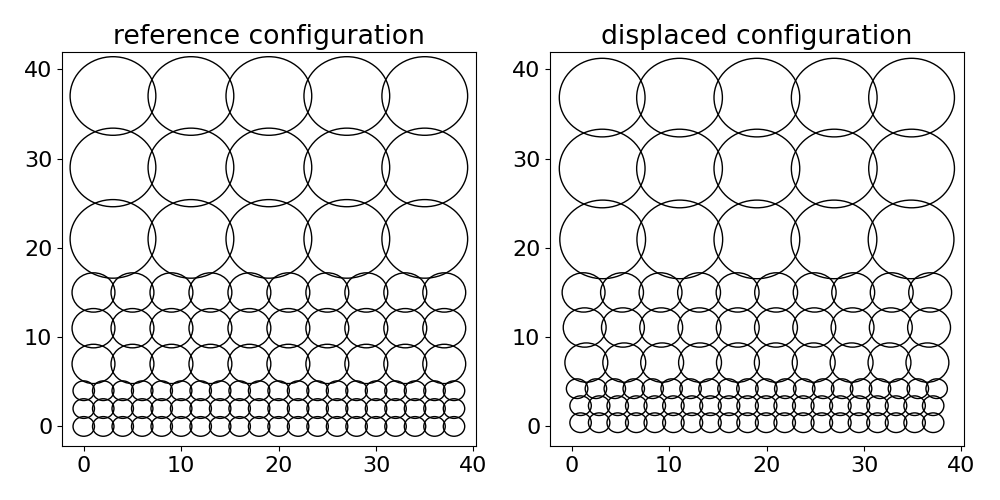

In [27]:
# quick 2D visualization of the packings w/ overlap
# this has limited applicability to the 3D packings, so it's above reading in those
fig, axen = plt.subplots(1,2, figsize=(10,5))
axen[0].set_title("reference configuration")
axen[1].set_title("displaced configuration")
#ax.scatter(pos[0], pos[1])
ifac = 1.01
xmin, xmax = np.min(pos[0,:])-0.5*np.max(rad)*ifac, np.max(pos[0,:])+0.5*np.max(rad)*ifac
ymin, ymax = np.min(pos[1,:])-np.max(rad)*ifac*0.5, np.max(pos[1,:])+np.max(rad)*ifac*1.1
for i, ax in enumerate(axen):
    dispbool = i == 1
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    note = False # True: show particle number
    pps = range(totp) #range(totp) if totp < 200 else np.random.randint(0,totp,size=200)
    for p in pps:
        #print(posen[0][p], posen[1][p], raden[p])
        pa = patches.Circle((pos[0][p]+displ[0,p]*dispbool, pos[1][p]+displ[1,p]*dispbool),
                            radius=rad[p], fill=False)
        ax.add_patch(pa)
        if note:
            ax.annotate(str(p+1), (pos[0][p], pos[1][p])
                   # , fontsize=30
                       )
fig.tight_layout()
fig.savefig("ref-displ.pdf", bbox_inches="tight")

<IPython.core.display.Javascript object>


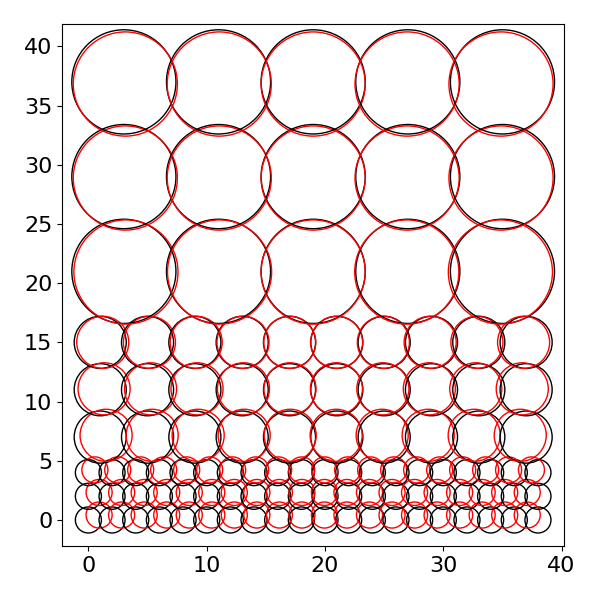

In [12]:
# quick 2D visualization of the packings w/ overlap
# this has limited applicability to the 3D packings, so it's above reading in those
fig, ax = plt.subplots(figsize=(6,6))

#ax.scatter(pos[0], pos[1])
xmin, xmax = np.min(pos[0,:])-np.max(rad)*0.5, np.max(pos[0,:])+np.max(rad)*0.5
ymin, ymax = np.min(pos[1,:])-np.max(rad)*1.01, np.max(pos[1,:])+np.max(rad)*1.01
ifac = 1.01
xmin, xmax = np.min(pos[0,:])-0.5*np.max(rad)*ifac, np.max(pos[0,:])+0.5*np.max(rad)*ifac
ymin, ymax = np.min(pos[1,:])-np.max(rad)*ifac*0.5, np.max(pos[1,:])+np.max(rad)*ifac*1.1

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)



note = False # True: show particle number
pps = range(totp) #range(totp) if totp < 200 else np.random.randint(0,totp,size=200)
for p in pps:
    #print(posen[0][p], posen[1][p], raden[p])
    pa = patches.Circle((pos[0][p], pos[1][p]), radius=rad[p], fill=False)
    pa2 = patches.Circle((pos[0][p]+displ[0,p], pos[1][p]+displ[1,p]),
                         radius=rad[p], fill=False, color="red")
    ax.add_patch(pa)
    ax.add_patch(pa2)
#ax.plot([], [], color="black", label="reference")
#ax.plot([], [], color="red", label="displaced")
#fig.legend()
fig.tight_layout()
fig.savefig("ref-displ.pdf", bbox_inches="tight")

To make this more quantitative the displacement and strains are considered next. A zero order approximation is to simply look at the maximum displacement on the lowest and highest layer (smallest and largest particles) and compare their displacements. 

In [13]:
uniqy = np.unique(pos[1,:])
miny, maxy = np.min(uniqy), np.max(uniqy)
us = []
for ypos in [miny, maxy]:
    filt = pos[1,:] == ypos
    ldispl = np.max(np.abs(displ[0,filt]))
    us.append(ldispl)
    print(ypos, ldispl)

0.0 0.9068181819319644
37.0 0.12272727272462536


In [14]:
us[0] / us[1]

7.3888888899753935

And we can observe a factor of ~7.4 more displacement in the bottom layer, as a result of two doublings of particle size. To make this a bit better spatially resolved, a discrete field is filled by the observed displacements which gives us a general idea of the displacement distribution in space.

In [15]:
# sample displacement into discrete field
# would be nicer to get a continuous field instead of jumps
xmin, xmax = np.min(pos, axis=1), np.max(pos, axis=1)
deltax = 0.1
isize = ((xmax-xmin)/deltax).astype(np.int32)
fieldx = np.zeros(isize)
fieldy = np.zeros(isize)
def particle2field(x, y):
    return int(x/deltax), int(y/deltax)
def field2particle(x, y):
    return x*delta, y*deltax

In [16]:
def fillCircle(field, cx, cy, r, value):
    cent = np.array([cx, cy])
    mins = cent-r
    maxs = cent+r
    rsq = r**2
    sh = field.shape
    # sanity checks
    for i in range(2):
        if mins[i] < 0 :
            mins[i] = 0
        if maxs[i] >= sh[i]:
            maxs[i] = sh[i]
    for x in range(mins[0], maxs[0]):
        for y in range(mins[1], maxs[1]):
            dloc = (x-cx)**2 + (y-cy)**2
            if (dloc <= rsq):
                field[x,y] = value

In [17]:
for i in range(totp):
    # disgusting O(n * r^2) complexity
    px, py = pos[:,i]
    fr = int(rad[i]/deltax)
    fx, fy = particle2field(px, py)
    fillCircle(fieldx, fx, fy, fr, displ[0,i])
    fillCircle(fieldy, fx, fy, fr, displ[1,i])

In the following displacement map a gradient in y (right) is quite evident, though whether it is linear or not is not so visible; hence a cut is made to show the actual profile.

<IPython.core.display.Javascript object>


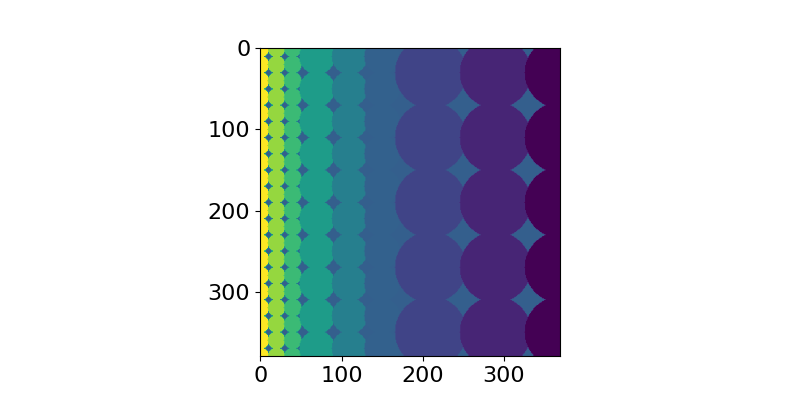

In [18]:
# gradient is somewhat visible here, but becomes clearer in a cut
fig, ax = plt.subplots()
ax.imshow(fieldy) 

The displacement in (x, y), when plotted over the y-coordinate, show a position dependence.
This is the result of adding the radius dependence to the system, as the RHS is now dependent on it and hence the magnitude of the displacement jump.

NB: The plot is over the field coordinate which is the particle coordinate divided by the field spacing (deltax). Furthermore, the jumps to 0 come from the discrete representation of the displacement field --- where there are no particles, the displacement is undefined and set to zero.

Note that when plotted over the x-coordinate the gradient in y vanishes, because particles within a layer have no displacement jump in y. Contrariwise, they do have a displacement jump in x, but it results in a linear profile.

<IPython.core.display.Javascript object>


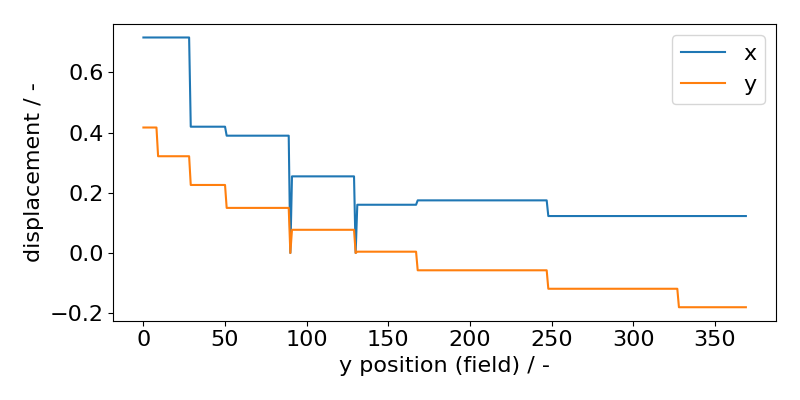

In [19]:
# displacements over the y-coordinate = direction where the grain size gradient is present
# this yields a gradient in both displacements
fig, ax = plt.subplots()
ax.plot(fieldx[40,:], label="x")
ax.plot(fieldy[40,:], label="y")
ax.legend()
ax.set_xlabel("y position (field) / -")
ax.set_ylabel("displacement / -")
fig.tight_layout()

In [20]:
# displacements over the x-coordinate = direction where the grain size is constant
# constant displacement in y (no sliding) but linear function in x = constant strain 
fig, ax = plt.subplots()
ax.plot(fieldx[:,40], label="x")
ax.plot(fieldy[:,40], label="y")
ax.legend()
ax.set_xlabel("x position (field) / -")
ax.set_ylabel("displacement / -")
fig.tight_layout()

<IPython.core.display.Javascript object>

Since the field calculation necessarily have regions of uniform displacement with jumps between them, which makes the calculation of a strain as a gradient of displacement of little value, we move back to the particle picture for the strain calculations.

The first method exploits the layering in the y direction (and to a lesser extent x):
Within each y-layer, particles of uniform size are found.
Since y=const. only the strain normal to this (x) is calculated.
The same applies for x-"layers", but in this case the layering is more implicit than explicit and the strain in y is calculated.

In [21]:
# divide domain into "layers" according to the unique particle positions
# this really only works for the y direction since this is the layering direction
# but by including the particle size information one can also make a statement about the x "layers"
uniqx = np.unique(pos[0,:])
uniqy = np.unique(pos[1,:])
rx, ry = [], []
epseny = []
for y in uniqy:
    filt = pos[1,:] == y
    fdispl = displ[0,filt]
    dudx = np.gradient(fdispl, pos[0,filt])
    epseny.append(np.average(dudx))
    ry.append(np.average(rad[filt]))
epsenx = []
for x in uniqx:
    filt = pos[0,:] == x
    fdispl = displ[1,filt]
    dudx = np.gradient(fdispl, pos[1,filt])
    epsenx.append(np.average(dudx))
    rx.append(np.average(rad[filt]))
rx, ry = [np.array(x) for x in [rx, ry]]

In the following scatterplots of the strain over the layer positions are shown.
The marker size is scaled by the particle radius on that layer.
What is generally observed is that larger particles experience less strain just as one would expect.

<IPython.core.display.Javascript object>


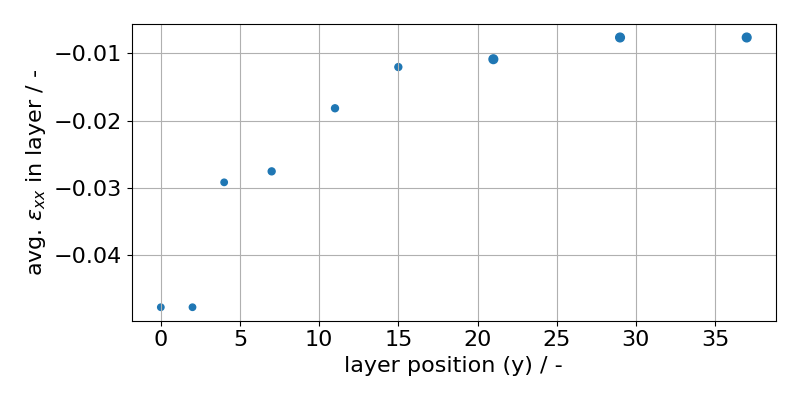

In [22]:
fig, ax = plt.subplots()
ax.scatter(uniqy, epseny, s=ry**2+20)
ax.set_xlabel("layer position (y) / -")
ax.set_ylabel("avg. $\epsilon_{xx}$ in layer / -")
#ax.scatter(uniqx, epsenx)
ax.grid(True)
fig.tight_layout()

<IPython.core.display.Javascript object>


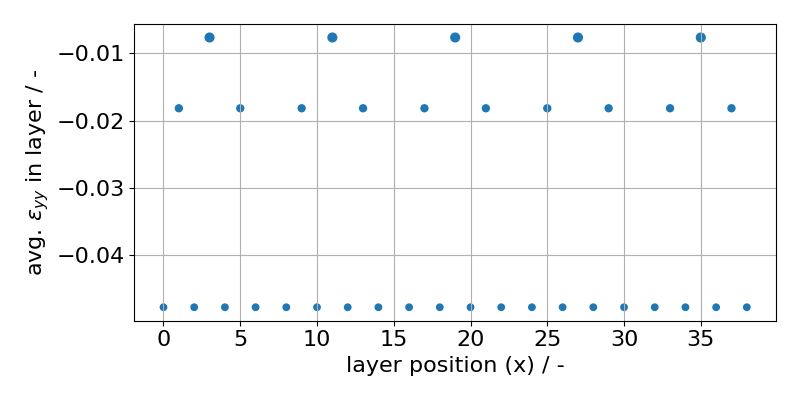

In [23]:
fig, ax = plt.subplots()
# again, smaller particles experience higher strain = differential densification
# note the constant strain levels for each particle size:
# since there is no grain size gradient in x, each x-"layer" densifies uniformly in x
# in contrast to the non-uniform densification resulting from the strain gradient in y
ax.scatter(uniqx, epsenx, s=rx**2+20)
ax.set_xlabel("layer position (x) / -")
ax.set_ylabel("avg. $\epsilon_{yy}$ in layer / -")
ax.grid(True)
#ax.scatter(uniqx, epsenx)
fig.tight_layout()

Another method exploiting the layering is to simply take forward differences between the particles, as they are ordered linearly starting from the smallest. This requires filtering out out-of-layer connections, which is actually simply ensuring that there is a nonzero positive difference in the layer direction between the particle's positions (dx > 0). The positivity requirement comes from wrapping from one layer to the next.

In [24]:
# forward differences between particle i, i+1 as local strain gauges
# this will jump at the end of each layer
dx = np.diff(pos[0,:])
dy = np.diff(pos[1,:])
# filters remove the jumps and the zero-diffs due to being on the same x or y coordinate
filt = dx > 0
filt2 = dy > 0

du = np.diff(displ[0,:])
dv = np.diff(displ[1,:])
eps = du[filt] / dx[filt]
epsy = dv[filt2] / dy[filt2]

<IPython.core.display.Javascript object>


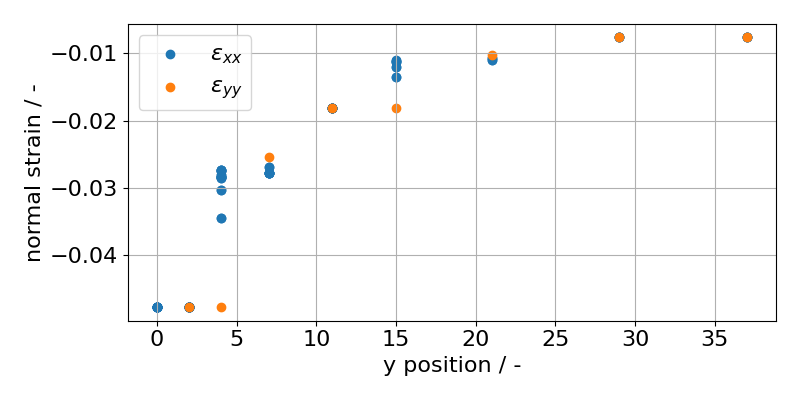

In [25]:
# again, a strain gradient is evident here
fig, ax = plt.subplots()
#ax.scatter(pos[0,1:][filt], eps, label="$\epsilon_{xx}$") # not plotted due to different sizes
# ^ shows roughly constant strain in each layer before going to the next
ax.scatter(pos[1,1:][filt], eps, label="$\epsilon_{xx}$") # not plotted due to different sizes
ax.scatter(pos[1,1:][filt2], epsy, label="$\epsilon_{yy}$")
ax.set_xlabel("y position / -")
ax.set_ylabel("normal strain / -")
ax.grid(True)
ax.legend()
fig.tight_layout()
fig.savefig("straingradient.pdf", bbox_inches="tight")

Both calculation methods agree on the magnitude of the strain and its dependence on the y position and therefore grain size. Thus the model is capable of representing differential densification.

It should be noted however that the phase-field implementation uses an approximation method for solving the system, which is solved here by the LSQR algorithm. This comes from two points which are handily ignored in the present notebook:

- The RHS and contact matrix are determined during the phase-field calculation, which is done in parallel on many processes.
- The size of the contact matrix (and associated $O(N^2)$ quantities) explodes if naively stored on each process.

The second point is easily understood to be problematic even for modest system sizes of about 4000 particles:
For each pair 40 byte of data needs to be stored, which results in a whopping 640MB memory usage. Not terrible if it's on one process, but if it's mirrored on each process then one is likely to use half the system memory of modern HPC systems for redundant data storage. The data locally calculated during point 1 also needs to be transferred to actually build the matrix and RHS, with a similar amount of communication per process then being necessary, turning the problem into one completely bound by communication.

In order to avoid this, the necessary data for building the matrix/RHS is kept purely locally by assigning a set of grains $[a, a+k]$ to each process and all updates to concerning the matrix/RHS entries for these grains only get transferred to this single process. The process-local storage is kept sparse as well and thus the memory/communication cost is effectively constant in a weak scaling sense. This however makes solving the equation with a standard solver quite troublesome, as each process only has access to its own segmented set of grain information. While there are ways to parallelize this calculation, the expected communication overhead was deemed to be too large (cf. Seiz2023b). Hence a simple linear ansatz is taken for the displacement field --- if it's actually linear, the match is quite good as can be seen in Seiz2023b. However, if it is not, the solution has little to do with the actual displacement field.